In [1]:
import sys
sys.path.insert(0, '..') #appends project root to path in order to import project packages since `noteboks_dev` is not on the root


# Code

In [2]:
#export
from functools import reduce

from typing import Union

from scipy import sparse
import numpy as np

from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import normalize, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import make_pipeline

from joblib import effective_n_jobs, Parallel, delayed

from sknetwork.clustering import KMeans, Louvain, PropagationClustering

from heartwood.utils import hstack, RobustEncoder, sparse_dot_product

import pandas as pd

/Users/alan.ganem/dev/personal/heterogeneous-metric-learning/hml/heartwood/utils.py:21: UserWarning: could not load sparse_dot_topn: No module named 'sparse_dot_topn'
  warn(f'could not load sparse_dot_topn: {e}')


In [3]:
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor

## Data

In [4]:
#session of variables to testing sessions
n_features = 7
cardinality_per_feature = 1000
n_classes = 5
n_reg_dims = 2


X = np.random.randint(0,cardinality_per_feature,(1000,n_features))

y_class = np.random.randint(0,n_classes, 1000)
y_reg = np.random.randn(1000,n_reg_dims)

In [5]:
#export
from sklearn.datasets import make_regression

def sigmoid(x):
    return 1/(1+np.exp(x))

def make_bimodal_assymetric_regression(
    n_samples=100000,
    bimodal_factor_weight = 2,
    n_features=15,
    n_informative=6,
    n_targets=2,
    bias=500,
    effective_rank=None,
    tail_strength=10,
    noise=150,
    shuffle=True,
    coef=False,
    random_state=None
):
    
    X,y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_targets=n_targets,
        bias=bias,
        effective_rank=effective_rank,
        tail_strength=tail_strength,
        noise=noise,
        shuffle=shuffle,
        coef=coef,
        random_state=random_state
    )


    #make one of X[1] feature mode weightening    
    bimodal_factors = (sigmoid(bimodal_factor_weight*X[:,-1]) > np.random.random(size = X.shape[0])).astype(int)
    bimodal_factors[bimodal_factors == 0] = -1
    bimodal_factors = bimodal_factors.reshape(-1,1)

    y = bimodal_factors*y
    
    return X,y

In [1276]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression, make_blobs
import seaborn as sns

%matplotlib inline

X, y = make_classification(
    n_samples = 100_000,
    n_features = 8,
    n_informative = 8,
    n_redundant = 0,
    #bias = 10,
    #noise = 10,
    n_classes = 6,
    n_clusters_per_class = 2,
    hypercube = True,
)


blobs, labels = make_blobs(n_samples = 10_000,cluster_std = 3, n_features = 4)
#sns.scatterplot(*blobs.T, hue = labels)
#plt.show()

## Object exploration

In [515]:
from lightgbm import LGBMClassifier,LGBMRegressor,LGBMRanker


In [516]:
clf = LGBMClassifier().fit(X,y)

In [517]:
#sns.jointplot(data = model_df, x = "count", y = "unit_parent_gain")

In [518]:
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer

In [519]:



model_df = clf.booster_.trees_to_dataframe()
leafs = clf.predict(X, pred_leaf = True)

d_cols = ["split_gain","parent_index","node_index","count"]
parent_split_gain = pd.merge(model_df[d_cols], model_df[d_cols], left_on = "parent_index", right_on = "node_index", how = "left")

root_nodes = model_df[model_df["parent_index"].isna()][["tree_index","node_index"]].rename(columns={"node_index":"root_node"})
model_df = model_df.merge(root_nodes, how = "left", on = "tree_index")

model_df["parent_gain"] = parent_split_gain["split_gain_y"]
#model_df["parent_count"] = parent_split_gain["count_y"]
model_df["unit_parent_gain"] = model_df["parent_gain"]/model_df["count"]
model_df["unit_parent_gain"] = model_df["unit_parent_gain"].fillna(0)
#model_df["unit_gain"] = model_df["split_gain"]/model_df["count"]
model_df["inverse_count"] = 1/model_df["count"]
model_df["unit_weight"] = model_df["weight"]/model_df["count"]

model_df["leaf_index"] = model_df["node_index"].str.split("-").str[1].str[1:].astype(int)
model_df["leaf_index"] = np.where(model_df["right_child"].isna(), model_df["leaf_index"], None)

#path_indpr = np.hstack([[0], model_df.reset_index().groupby("tree_index")["index"].max().values])
leaf_indexes = model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "leaf_index"]).index.values
leaf_index_map = model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "leaf_index"])["node_index"]
path_pairs_df = model_df.dropna(subset = ["leaf_index"])[["root_node","node_index"]]



g = nx.Graph()
g.add_nodes_from(model_df["node_index"])
#if weighted:    
#    edge_weight_column = "parent_gain"
#    z = list(tuple(i) for i in tuple(model_df[["parent_index","node_index",edge_weight_column]].dropna().values))
#    g.add_weighted_edges_from(z)

z = list(tuple(i) for i in tuple(model_df[["parent_index","node_index"]].dropna().values))
g.add_edges_from(z)
    
    
leafs = clf.predict(X, pred_leaf = True)
leaf_encoder = OneHotEncoder().fit(leafs)

#encoded = leaf_encoder.transform(leafs)
    
#terminal_nodes = np.array(np.split(encoded.nonzero()[1], leafs.shape[0]))

In [520]:
#check leaf nodes orderning according to output leaf nodes of estimator
(model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "leaf_index"])["count"].values == OneHotEncoder().fit_transform(leafs).sum(0).A.flatten()).mean()

1.0

In [521]:
from tqdm import tqdm
node_weight = "unit_parent_gain"
path_pairs = list(tuple(i) for i in tuple(path_pairs_df.values))
paths = np.array([np.array(nx.shortest_path(g, *i)) for i in path_pairs])

weights_df = model_df.set_index("node_index")[[node_weight, "tree_index", "node_depth"]]
weights_df["network_weight"] = np.nan
for i in (np.arange(len(path_pairs_df["node_index"]))):
    weights_df.loc[path_pairs_df.loc[path_pairs_df.index[i],"node_index"], "network_weight"] = weights_df.loc[paths[i], node_weight].sum()
    

/var/folders/8k/0nhrnbdn0zd5s2bbfsjt7crm0000gn/T/ipykernel_88122/1002890969.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  paths = np.array([np.array(nx.shortest_path(g, *i)) for i in path_pairs])


<AxesSubplot: xlabel='tree_index'>

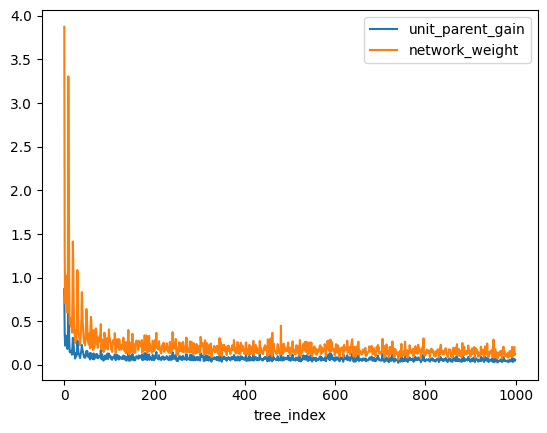

In [522]:
leaf_weights = weights_df.loc[leaf_index_map, "network_weight"].values.reshape(1,-1)
weights_df.groupby("tree_index").mean()[[node_weight, "network_weight"]].plot()

## Custom LGBM

In [523]:
class CustomLGBMClassifier(LGBMClassifier):
    #TODO: calculate node weight as the cumulative information gain up to that node
    def apply(self, X):
        return self.predict(X, pred_leaf = True)
    
    def transform(self, X):
        X = self.apply(X)
        X = self.encoder_.transform(X)
        X = X.multiply(self.leaf_weights_)
        return X
    
    def decision_path(self, X, decision_weight = None):
        leafs = self.apply(X)
        return self._transform_decision_path(leafs)
    
    def fit(self, X, y = None, sample_weight = None, leaf_weights_strategy = "unit_parent_gain", **kwargs):
        
        super().fit(X, y=y, sample_weight=sample_weight, **kwargs)                
        
        self._set_leaf_weights(leaf_weights_strategy)
        self.encoder_ = OneHotEncoder().fit(self.apply(X))
        return self
    
    
    def _set_leaf_weights(self, strategy):
        
        VALID_STRATEGIES = ["unit_parent_gain","unit_weight", "inverse_count", None]
        if not strategy in VALID_STRATEGIES:
            raise ValueError(f"strategy should be one of {VALID_STRATEGIES}, got {strategy}")
        
        if strategy is None:
            self.leaf_weights_ = None
        else:    
            model_df = self.booster_.trees_to_dataframe()

            d_cols = ["split_gain","parent_index","node_index","count"]
            parent_split_gain = pd.merge(model_df[d_cols], model_df[d_cols], left_on = "parent_index", right_on = "node_index", how = "left")

            root_nodes = model_df[model_df["parent_index"].isna()][["tree_index","node_index"]].rename(columns={"node_index":"root_node"})
            model_df = model_df.merge(root_nodes, how = "left", on = "tree_index")

            model_df["parent_gain"] = parent_split_gain["split_gain_y"]
            #model_df["parent_count"] = parent_split_gain["count_y"]
            model_df["unit_parent_gain"] = model_df["parent_gain"]/model_df["count"]
            model_df["unit_parent_gain"] = model_df["unit_parent_gain"].fillna(0)
            #model_df["unit_gain"] = model_df["split_gain"]/model_df["count"]
            model_df["inverse_count"] = 1/model_df["count"]
            model_df["unit_weight"] = model_df["weight"]/model_df["count"]

            model_df["leaf_index"] = model_df["node_index"].str.split("-").str[1].str[1:].astype(int)
            model_df["leaf_index"] = np.where(model_df["right_child"].isna(), model_df["leaf_index"], None)

            #path_indpr = np.hstack([[0], model_df.reset_index().groupby("tree_index")["index"].max().values])
            leaf_indexes = model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "leaf_index"]).index.values
            leaf_index_map = model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "leaf_index"])["node_index"]
            path_pairs_df = model_df.dropna(subset = ["leaf_index"])[["root_node","node_index"]]



            g = nx.Graph()
            g.add_nodes_from(model_df["node_index"])

            z = list(tuple(i) for i in tuple(model_df[["parent_index","node_index"]].dropna().values))
            g.add_edges_from(z)

            leaf_weight_strategy = "unit_parent_gain"
            path_pairs = list(tuple(i) for i in tuple(path_pairs_df.values))
            paths = np.array([np.array(nx.shortest_path(g, *i)) for i in path_pairs])

            weights_df = model_df.set_index("node_index")[[leaf_weight_strategy, "tree_index", "node_depth"]]
            weights_df["network_weight"] = np.nan
            for i in np.arange(len(path_pairs_df["node_index"])):
                weights_df.loc[path_pairs_df.loc[path_pairs_df.index[i],"node_index"], "network_weight"] = weights_df.loc[paths[i], leaf_weight_strategy].sum()
        
            leaf_weights = weights_df.loc[leaf_index_map, "network_weight"].values.reshape(1,-1)
            self.leaf_weights_ = leaf_weights
        return



# Experimenting with embeddings

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

In [514]:
#X = data["data"]
#y = KBinsDiscretizer(n_bins = 10, encode = "ordinal").fit_transform(data["target"].reshape(-1,1)).flatten()

In [1277]:
clf = CustomLGBMClassifier(
    boosting_type = "rf",
    bagging_fraction = 0.8,
    bagging_freq = 1
).fit(X,y)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


/var/folders/8k/0nhrnbdn0zd5s2bbfsjt7crm0000gn/T/ipykernel_88122/3140774239.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  paths = np.array([np.array(nx.shortest_path(g, *i)) for i in path_pairs])


In [1278]:
clf.transform(X[0:10]).data

array([0.15728832, 0.81801621, 0.45047093, ..., 0.3290391 , 0.81230041,
       0.95138528])

In [1279]:
from sknetwork.clustering import Louvain, PropagationClustering
from sknetwork.clustering import KMeans as GraphKMeans
from fa2l import force_atlas2_layout
from umap import UMAP
import networkx as nx
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline

In [1280]:
leaf_embs = clf.transform(X)

In [1557]:

if not sample_weight is None:
    com_detector = GraphKMeans(n_clusters = 50).fit(leaf_embs.multiply(sample_weight.reshape(-1,1)))
else:
    com_detector = GraphKMeans(n_clusters = 50).fit(leaf_embs)
#com_detector = Louvain(2).fit(leaf_embs)

In [ ]:

prod = normalize(leaf_embs, "l1")@com_detector.membership_col_
#prod = leaf_embs@com_detector.membership_col_


<AxesSubplot: >

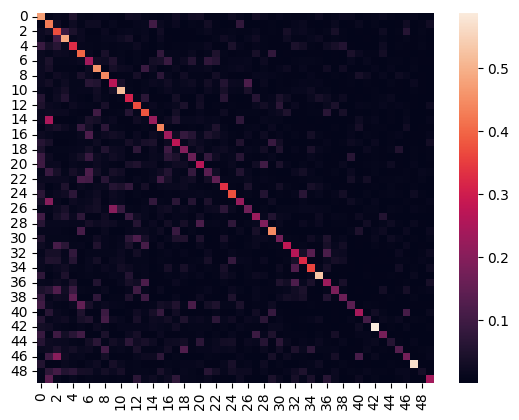

In [1716]:
import seaborn as sns
beta = 1
agg_network = com_detector.aggregate_.copy()
importances = com_detector.aggregate_.sum(1)
sizes = agg_network.diagonal()
#agg_network.setdiag(0)
#agg_network.data = 1/minmax_scale(agg_network.data.reshape(-1,1), (1e-1,1e1)).flatten()
#agg_network = normalize(agg_network, "l1")
agg_network.data = agg_network.data**beta
agg_network = normalize(agg_network, "l1")

agg_network.eliminate_zeros()
sns.heatmap(agg_network.A)

In [1717]:
from sklearn.preprocessing import quantile_transform, minmax_scale

In [1738]:
from sknetwork.embedding import Spectral, ForceAtlas, LouvainEmbedding
# net_embs = force_atlas2_layout(
#     nx.from_scipy_sparse_array(normalize(agg_network, "l1")),
#     lin_log_mode = False,
#     prevent_overlapping=True,
#     edge_weight_influence=1.0,
#     outbound_attraction_distribution=False,
#     barnes_hut_optimize=True,
#     scaling_ratio=2.0,
#     strong_gravity_mode=False,
#     gravity=1.0,
# )


# net_embs = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(normalize(agg_network)))
# net_embs = np.vstack(net_embs.values())
net_embs = UMAP(metric = "cosine", random_state=42, n_neighbors = 15).fit_transform(normalize(agg_network))
#net_embs = UMAP(metric = "euclidean", random_state=42, n_neighbors = 15).fit_transform(prod.T)
#net_embs = ForceAtlas(lin_log = False, gravity_factor = 0.01, repulsive_factor=1).fit_transform(agg_network)


In [1739]:
from sklearn.preprocessing import normalize

In [1740]:
max_archetypes = 30
alpha = 1


Xt = prod.A

argsort = np.argsort(Xt, axis = 1)

#TODO: decide how to handle when both max_cumulative_membership and topn_archetypes_ are not None
#bottom_n
zeros_idxs = argsort[:,:-max_archetypes]
flat_zeros_idxs = (zeros_idxs + np.arange(prod.shape[0]).reshape(-1,1)*prod.shape[1]).flatten()

#replace values using put            
Xt.put(flat_zeros_idxs, 0)

Xt = normalize(Xt**alpha, norm = "l1")

graph_embs = Xt@(net_embs)

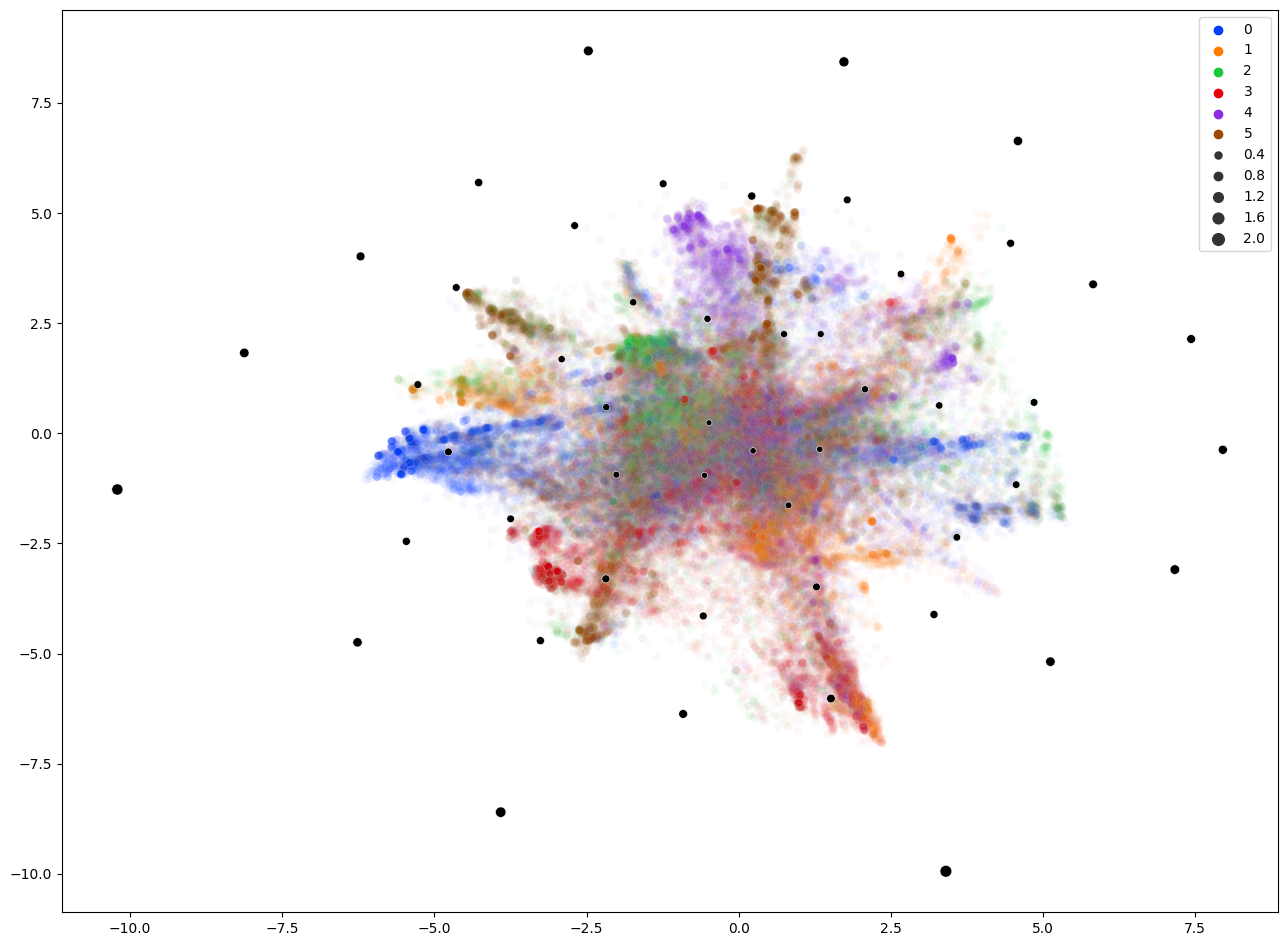

In [1737]:
sns.scatterplot(
    x = graph_embs.T[0],
    y = graph_embs.T[1],
    alpha = 0.03,
    #hue = np.isin(y, 1 + np.array([0,1])),#np.random.choice(y, len(y)),
    hue = y,#np.random.choice(y, len(y)),
    #palette = "YlOrBr",
    palette = "bright",
)

sns.scatterplot(
    x = net_embs.T[0],
    y = net_embs.T[1],
    size = importances.A.flatten(),
    color = "black"
)
plt.subplots_adjust(-1,-1)

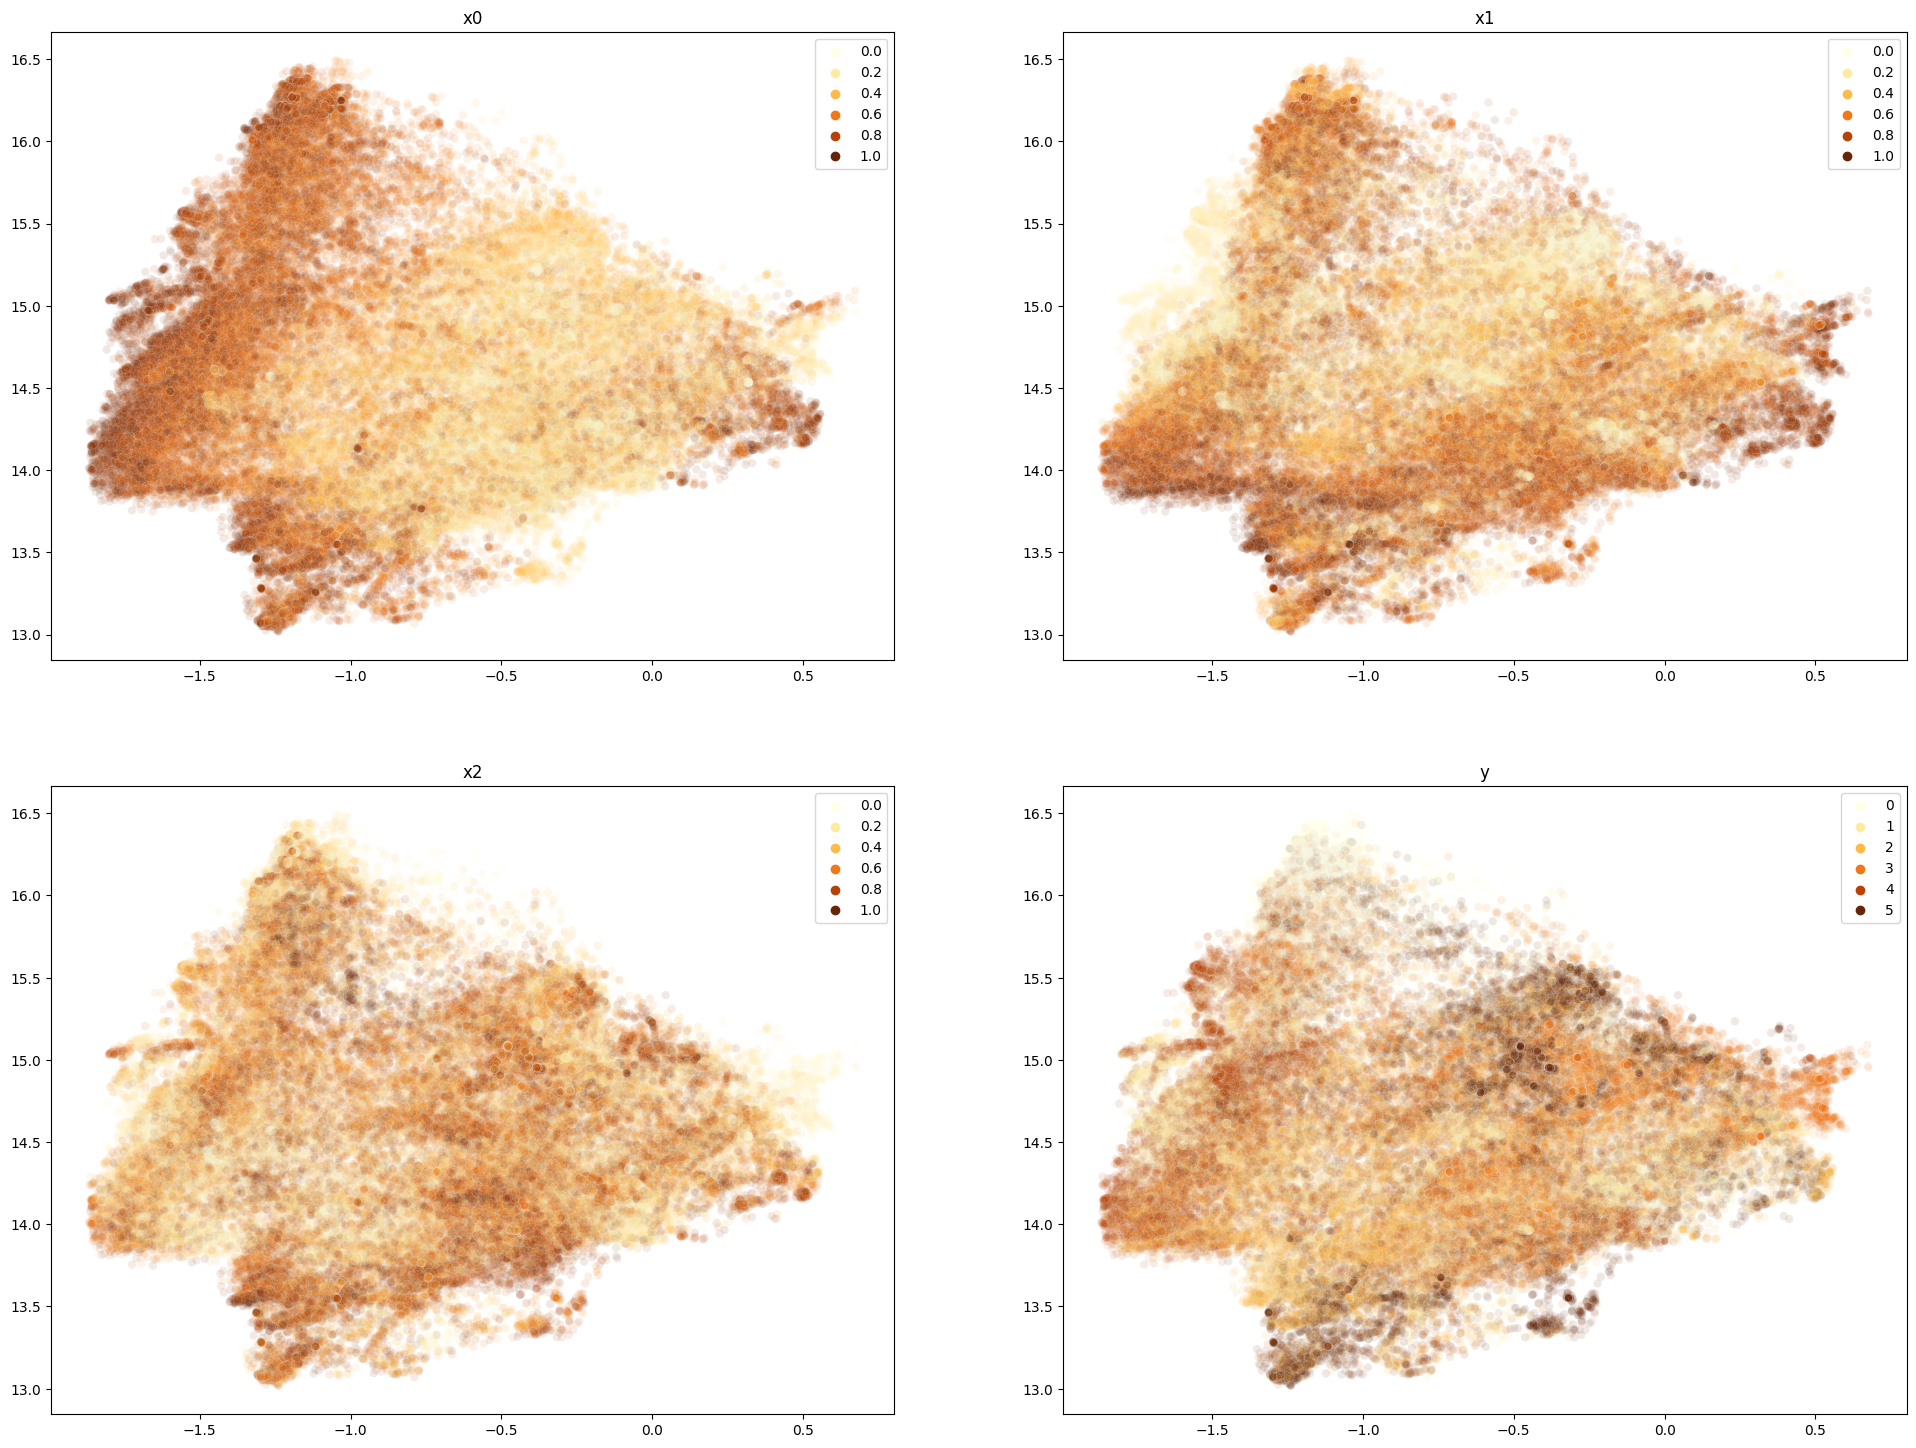

In [1708]:

fig,axs = plt.subplots(2,2)

sns.scatterplot(
    x = graph_embs.T[0],
    y = graph_embs.T[1],
    alpha = 0.1,
    hue = quantile_transform(X[:,0:1]).flatten(),
    palette = "YlOrBr",
    ax = axs[0,0],    
)
sns.scatterplot(
    x = graph_embs.T[0],
    y = graph_embs.T[1],
    alpha = 0.1,
    hue = quantile_transform(X[:,1:2]).flatten(),
    palette = "YlOrBr",
    ax = axs[0,1],
)

sns.scatterplot(
    x = graph_embs.T[0],
    y = graph_embs.T[1],
    alpha = 0.1,
    hue = quantile_transform(X[:,2:3]).flatten(),
    palette = "YlOrBr",
    ax = axs[1,0],
)

sns.scatterplot(
    x = graph_embs.T[0],
    y = graph_embs.T[1],
    alpha = 0.1,
    hue = y,
    palette = "YlOrBr",
    ax = axs[1,1],
)


axs[0,0].set_title ("x0")
axs[0,1].set_title ("x1")
axs[1,0].set_title ("x2")
axs[1,1].set_title ("y")
plt.subplots_adjust(-2,-2)
#sns.scatterplot(*embs.T)

> Comparing with regular leaf embedding

In [1572]:
point_embs = UMAP(metric = "hamming").fit_transform(clf.apply(X[:5000]))


/Users/alan.ganem/miniconda3/envs/hml/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


<AxesSubplot: >

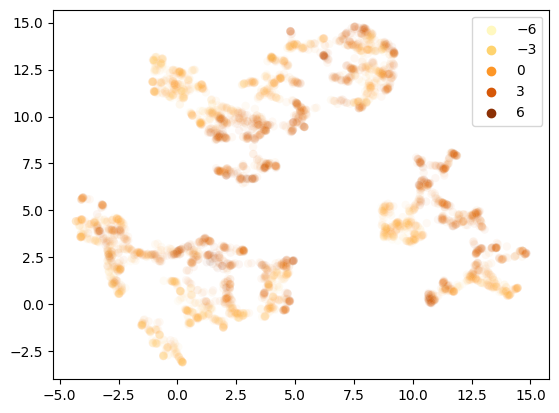

In [1707]:
sns.scatterplot(
    x = point_embs.T[0],
    y = point_embs.T[1],
    alpha = 0.05,
    #hue = np.isin(y, 1 + np.array([0,1])),#np.random.choice(y, len(y)),
    hue = X[:5000,0],#np.random.choice(y, len(y)),
    #palette = "YlOrBr",
    palette = "YlOrBr",
)


# WRAP IN CLASS

In [1747]:
com_detector.membership_col_


<18600x50 sparse matrix of type '<class 'numpy.float64'>'
	with 327798 stored elements in Compressed Sparse Row format>

In [1777]:
from sklearn.base import TransformerMixin, BaseEstimator

class ForestInducedUMAP(BaseEstimator, TransformerMixin):
    
    def __init__(
        self,
        n_archetypes = 100,
        alpha = 1,
        beta = 1,
        n_neighbors=15,
        n_components=2,
        metric='cosine',
        normalize_connections = "l1",
        graph_clustering_kwargs = {},
        umap_kwargs = {},        
    ):
        
        self.n_archetypes = n_archetypes
        self.alpha = alpha
        self.beta = beta
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.metric = metric 
        self.normalize_connections = normalize_connections
        self.graph_clustering_kwargs = graph_clustering_kwargs
        self.umap_kwargs = umap_kwargs
        return
    
    
    
    def _get_graph_clusterer(self, X, sample_weight):
        
        if not sample_weight is None:
            com_detector = GraphKMeans(n_clusters = self.n_archetypes, **self.graph_clustering_kwargs).fit(X.multiply(sample_weight.reshape(-1,1)))
        else:
            com_detector = GraphKMeans(n_clusters = self.n_archetypes, **self.graph_clustering_kwargs).fit(X)
        
        return com_detector
    
    def _get_archetype_embeddings(self, X, com_detector):
        
        pointwise_membership = normalize(X, "l1")@com_detector.membership_col_
                
        agg_network = com_detector.aggregate_.copy()
        
        #agg_network.setdiag(0)
        #agg_network.data = 1/minmax_scale(agg_network.data.reshape(-1,1), (1e-1,1e1)).flatten()
        #agg_network = normalize(agg_network, "l1")
        agg_network.data = agg_network.data**self.alpha
        
        if not self.normalize_connections is None:
            agg_network = normalize(agg_network, self.normalize_connections)

        agg_network.eliminate_zeros()        
        return agg_network
    
    def _get_community_embeddings(self, agg_network, **umap_kwargs):
        net_embs = UMAP(**umap_kwargs).fit_transform(agg_network)
        return net_embs
    
    def fit(self, X, y = None, sample_weight = None):
        
        X = sparse.csr_matrix(X)
        #find graph comunities
        com_detector = self._get_graph_clusterer(X, sample_weight)
        
        importances = com_detector.aggregate_.sum(1).A
        sizes = com_detector.aggregate_.diagonal()             
        #
        agg_network = self._get_archetype_embeddings(X, com_detector)
        #fit aggregate graph embeddings
        net_embs = self._get_community_embeddings(
            agg_network,
            metric = self.metric,
            n_neighbors=self.n_neighbors,
            n_components=self.n_components,
            **self.umap_kwargs
        )
        
        self.archetype_importances_ = importances
        self.archetype_sizes_ = sizes
        self.agg_network_ = agg_network
        self.network_embeddings_ = net_embs
        self.leaf_memberships_ = com_detector.membership_col_
        return self
        
    def transform(self, X, beta = None):
        
        if beta is None:
            beta = self.beta
        else:
            beta = beta
        
        
        pointwise_membership = normalize(X, "l1")@self.leaf_memberships_
        
        pointwise_membership.data = pointwise_membership.data**beta
        pointwise_membership.eliminate_zeros()
        pointwise_membership = normalize(pointwise_membership, norm = "l1")

        embs = pointwise_membership@(self.network_embeddings_)
        return embs

In [1778]:
embeder = ForestInducedUMAP()

In [1793]:
leaf_embs = RandomTreesEmbedding().fit_transform(X)

embeder.fit(sparse.csr_matrix(leaf_embs)[:10000], sample_weight=y[:10000])

ForestInducedUMAP()

In [1798]:
embs = embeder.transform(leaf_embs, beta = 5)

In [1799]:
net_embs = embeder.network_embeddings_
importances = embeder.archetype_importances_

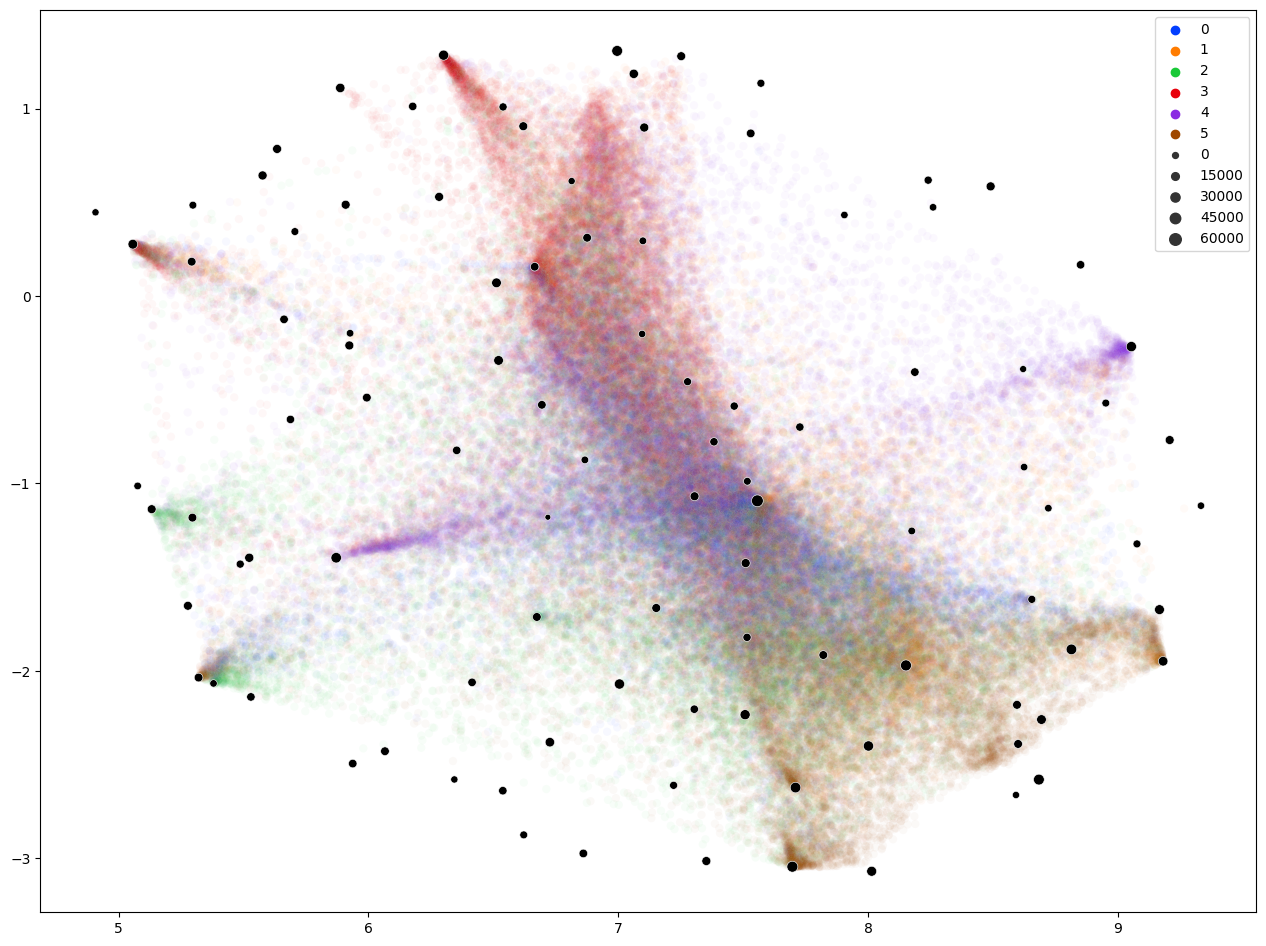

In [1800]:
sns.scatterplot(
    x = embs.T[0],
    y = embs.T[1],
    alpha = 0.03,
    #hue = np.isin(y, 1 + np.array([0,1])),#np.random.choice(y, len(y)),
    hue = y,#np.random.choice(y, len(y)),
    #palette = "YlOrBr",
    palette = "bright",
)

sns.scatterplot(
    x = net_embs.T[0],
    y = net_embs.T[1],
    size = importances.flatten(),
    color = "black"
)
plt.subplots_adjust(-1,-1)

# Other Estimators

In [448]:
    
class CustomLGBMRegressor(LGBMRegressor):
    
    def apply(self, X):
        return self.predict(X, pred_leaf = True)
    
    def decision_path(self, X, decision_weight = None):
        leafs = self.apply(X)
        return self._transform_decision_path(leafs)
    
    def fit(self, X, y = None, sample_weight = None, **kwargs):
        super().fit(X, y=y, sample_weight=sample_weight, **kwargs)
        model_df = self.booster_.trees_to_dataframe()
        node_weights = model_df[model_df["decision_type"].isna()]["weight"].values
        
        leafs = self.predict(X, pred_leaf = True)
        leaf_encoder = OneHotEncoder().fit(leafs)
        self.leaf_encoder_ = leaf_encoder
        self._fit_decision_path(leafs, model_df, decision_weight = "unit_parent_gain")
        self.node_weights_ = node_weights
        
        return self
    
    def _fit_decision_path(self, leafs, model_df, decision_weight = None):

        d_cols = ["split_gain","parent_index","node_index","count"]
        parent_split_gain = pd.merge(model_df[d_cols], model_df[d_cols], left_on = "parent_index", right_on = "node_index", how = "left")

        model_df["parent_gain"] = parent_split_gain["split_gain_y"]
        model_df["parent_count"] = parent_split_gain["count_y"]
        model_df["unit_parent_gain"] = model_df["parent_gain"]/model_df["count"]
        model_df["unit_gain"] = model_df["split_gain"]/model_df["count"]
        model_df["inverse_count"] = 1/model_df["count"]

        model_df["int_index"] = model_df["node_index"].str.split("-").str[1].str[1:].astype(int)
        model_df["leaf_index"] = np.where(model_df["right_child"].isna(), model_df["int_index"], np.nan)

        leaf_indexes = model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "int_index"]).index.values

        g = nx.DiGraph()
        g.add_nodes_from(model_df["node_index"])
        if not decision_weight is None:
            z = list(tuple(i) for i in tuple(model_df[["parent_index","node_index",decision_weight]].dropna().values))
            g.add_weighted_edges_from(z)
        else:
            z = list(tuple(i) for i in tuple(model_df[["parent_index","node_index"]].dropna().values))
            g.add_edges_from(z)

        node_decision_paths = nx.adjacency_matrix(g)
        paths = self._transform_decision_path(leafs)        
        self._leaf_decision_paths = paths
        return 

    def _transform_decision_path(self, leafs):
        encoded_leafs = self.leaf_encoder_.transform(leafs)
        terminal_nodes = np.array(np.split(encoded_leafs.nonzero()[1], leafs.shape[0]))
        paths = node_decision_paths[terminal_nodes.flatten()]
        paths = paths.reshape(leafs.shape[0], paths.shape[0]//leafs.shape[0]*paths.shape[1]).tocsr()

        return paths
    
class CustomLGBMRanker(LGBMRanker):
    
    def apply(self, X):
        return self.predict(X, pred_leaf = True)
    
    def decision_path(self, X, decision_weight = None):
        leafs = self.apply(X)
        return self._transform_decision_path(leafs)
    
    def fit(self, X, y = None, sample_weight = None, **kwargs):
        super().fit(X, y=y, sample_weight=sample_weight, **kwargs)
        model_df = self.booster_.trees_to_dataframe()
        node_weights = model_df[model_df["decision_type"].isna()]["weight"].values
        
        leafs = self.predict(X, pred_leaf = True)
        leaf_encoder = OneHotEncoder().fit(leafs)
        self.leaf_encoder_ = leaf_encoder
        self._fit_decision_path(leafs, model_df, decision_weight = "unit_parent_gain")
        self.node_weights_ = node_weights
        
        return self
    
    def _fit_decision_path(self, leafs, model_df, decision_weight = None):

        d_cols = ["split_gain","parent_index","node_index","count"]
        parent_split_gain = pd.merge(model_df[d_cols], model_df[d_cols], left_on = "parent_index", right_on = "node_index", how = "left")

        model_df["parent_gain"] = parent_split_gain["split_gain_y"]
        model_df["parent_count"] = parent_split_gain["count_y"]
        model_df["unit_parent_gain"] = model_df["parent_gain"]/model_df["count"]
        model_df["unit_gain"] = model_df["split_gain"]/model_df["count"]
        model_df["inverse_count"] = 1/model_df["count"]

        model_df["int_index"] = model_df["node_index"].str.split("-").str[1].str[1:].astype(int)
        model_df["leaf_index"] = np.where(model_df["right_child"].isna(), model_df["int_index"], np.nan)

        leaf_indexes = model_df.dropna(subset = ["leaf_index"]).sort_values(by = ["tree_index", "int_index"]).index.values

        g = nx.DiGraph()
        g.add_nodes_from(model_df["node_index"])
        if not decision_weight is None:
            z = list(tuple(i) for i in tuple(model_df[["parent_index","node_index",decision_weight]].dropna().values))
            g.add_weighted_edges_from(z)
        else:
            z = list(tuple(i) for i in tuple(model_df[["parent_index","node_index"]].dropna().values))
            g.add_edges_from(z)

        node_decision_paths = nx.adjacency_matrix(g)
        paths = self._transform_decision_path(leafs)        
        self._leaf_decision_paths = paths
        return 

    def _transform_decision_path(self, leafs):
                
        encoded_leafs = self.leaf_encoder_.transform(leafs)
        terminal_nodes = np.array(np.split(encoded_leafs.nonzero()[1], leafs.shape[0]))
        paths = node_decision_paths[terminal_nodes.flatten()]
        paths = paths.reshape(leafs.shape[0], paths.shape[0]//leafs.shape[0]*paths.shape[1]).tocsr()

        return paths

In [20]:
embeder = RandomTreesEmbedding().fit(X)

In [22]:
embeder.decision_path(X)

(<100000x5114 sparse matrix of type '<class 'numpy.int64'>'
 	with 59999609 stored elements in Compressed Sparse Row format>,
 array([   0,   57,  112,  167,  224,  283,  338,  401,  446,  503,  564,
         611,  664,  721,  778,  839,  884,  907,  970, 1025, 1078, 1125,
        1184, 1209, 1270, 1331, 1386, 1439, 1496, 1555, 1606, 1661, 1722,
        1767, 1828, 1853, 1872, 1933, 1980, 2031, 2082, 2129, 2190, 2249,
        2302, 2365, 2420, 2465, 2524, 2569, 2620, 2651, 2706, 2767, 2818,
        2861, 2912, 2955, 3012, 3059, 3122, 3167, 3230, 3281, 3322, 3381,
        3442, 3489, 3536, 3585, 3648, 3711, 3754, 3811, 3872, 3931, 3990,
        4029, 4086, 4111, 4144, 4197, 4250, 4309, 4362, 4417, 4460, 4507,
        4564, 4617, 4668, 4683, 4732, 4753, 4812, 4865, 4906, 4965, 5026,
        5057, 5114]))

In [527]:
clf = CustomLGBMClassifier(n_estimators = 10).fit(X,y)

/var/folders/8k/0nhrnbdn0zd5s2bbfsjt7crm0000gn/T/ipykernel_12463/2947498330.py:48: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  node_decision_paths = nx.adjacency_matrix(g)


/var/folders/8k/0nhrnbdn0zd5s2bbfsjt7crm0000gn/T/ipykernel_12463/2341249955.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clf.node_weights_)


<AxesSubplot: ylabel='Density'>

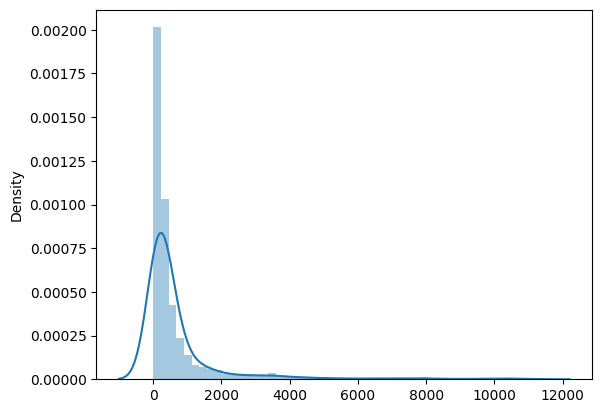

In [528]:
sns.distplot(clf.node_weights_)


In [529]:
(nodes.multiply(node_weights.reshape(1,-1)))

<10000x1240 sparse matrix of type '<class 'numpy.float64'>'
	with 400000 stored elements in COOrdinate format>

In [209]:
from sklearn.linear_model import LinearRegression

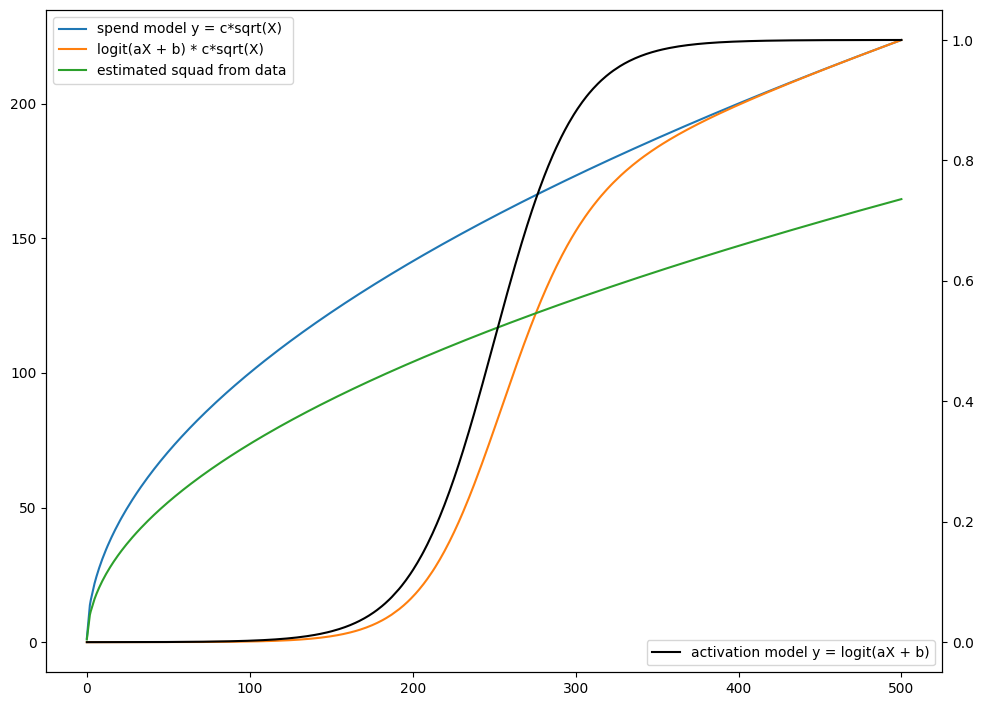

In [237]:
def sigmoid(X, a = 1, b = 0):
    return 1/(1 +np.exp(a*X +b))

x_ = np.random.random(1000)*500#100*abs(np.random.randn(1000))
x_ = np.sort(x_)

fig, ax = plt.subplots() 
ax_t = ax.twinx()
x_sig = sigmoid(x_, a = -0.04, b = 10)
x_quad = 10*np.power(x_, 1/2)
x_quad_sig = x_sig*x_quad

x_quad_estim = np.power(LinearRegression(fit_intercept = False).fit(np.power(x_, 1/2).reshape(-1,1), x_quad_sig).predict(np.power(x_, 1/2).reshape(-1,1)), 1)

ax_t.plot(x_,x_sig, color = "black", label = "activation model y = logit(aX + b)")
ax.plot(x_,x_quad, label = "spend model y = c*sqrt(X)")
ax.plot(x_,x_sig*x_quad, label = "logit(aX + b) * c*sqrt(X)")
ax.plot(x_,x_quad_estim, label = "estimated squad from data")
ax.legend(loc = "best")
ax_t.legend(loc = "lower right")
plt.subplots_adjust(-.5,-.5)

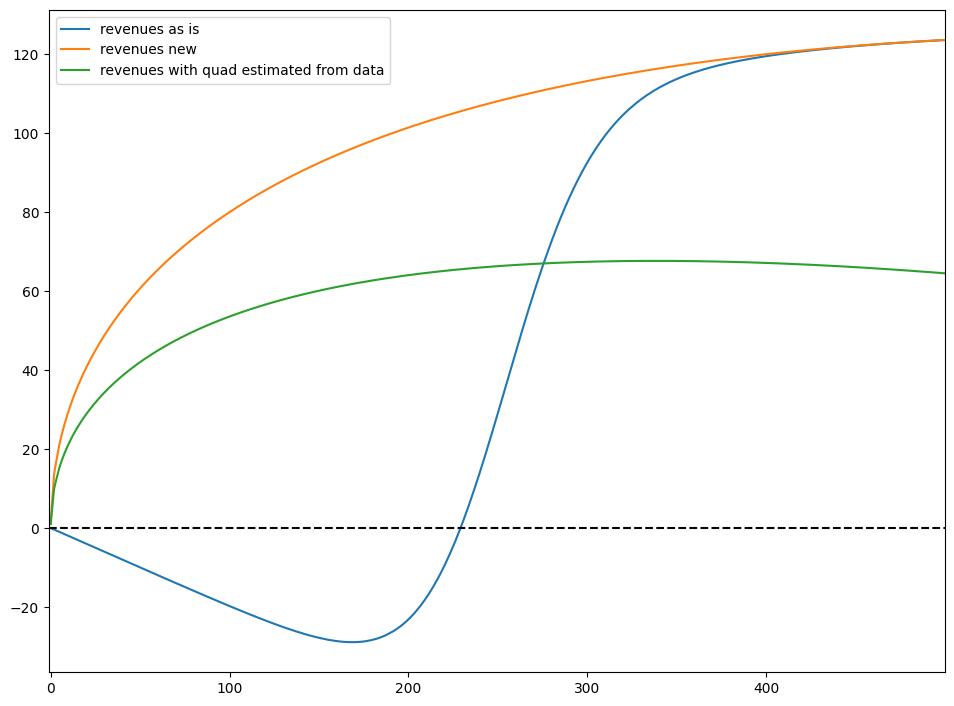

In [238]:

fig, ax = plt.subplots() 
#ax_t = ax.twinx()

risk = 0.2

rev = x_quad - risk*x_

try:
    ng_idx = (rev < 0).nonzero()[0][0]
except:
    ng_idx = len(rev) - 1


ax.plot(x_,x_sig*x_quad - risk*x_, label = "revenues as is")
ax.plot(x_,x_quad - risk*x_, label = "revenues new")
ax.plot(x_,x_quad_estim - risk*x_, label = "revenues with quad estimated from data")

ax.legend(loc = "best")
#ax_t.legend(loc = "lower right")
plt.axhline(0, color = "black", linestyle= "--")
plt.xlim(-1, x_[ng_idx])
#plt.ylim(-20, 30)
plt.subplots_adjust(-.5,-.5)